In [92]:
import numpy as np 
import pandas as pd 
import os
import warnings 
import pickle
import copy
import sys
import io 
from contextlib import contextmanager
import itertools as it 

from pymatgen.core import Structure 
from pymatgen.io.ase import AseAtomsAdaptor

from ase.mep import NEB 
from ase.optimize import MDMin,BFGS, BFGSLineSearch
from ase.mep import NEBTools 

from doped.generation import DefectsGenerator

from chgnet.model.dynamics import CHGNetCalculator

In [365]:
class INeb:
    '''class for setting up interstitial and interstitialcy NEBs'''
    def __init__(self,relax_with_chgnet=True,
                 **chgnet_kws):
        '''need more inits'''
        if relax_with_chgnet:
            self.cnc = CHGNetCalculator(**chgnet_kws)

        self.relax_models = {'MDMin': MDMin,
                             'BFGS': BFGS,
                             'BFGSLineSearch': BFGSLineSearch}
        
    @contextmanager
    def redirect_stdout(self,f):
        try:
            _stdout = sys.stdout
            sys.stdout = f
            yield
        finally:
            sys.stdout = _stdout

    def chgnet_relax(self,
                     structure,
                     fmax=0.1,
                     steps=1000,
                     relax_model='MDMin',
                     **relax_kws):
        
        self.chosen_relax_model = self.relax_models[relax_model] # this is so that things are consistent between this and NEB
        atoms = AseAtomsAdaptor.get_atoms(
            copy.deepcopy(structure)
        )  # convert pymatgen to ase
        atoms.calc = self.cnc
        dyn = self.relax_models[relax_model](atoms)
        dyn.run(fmax=fmax, steps=steps,**relax_kws)
        energy = atoms.get_potential_energy()
        struct = AseAtomsAdaptor.get_structure(atoms)
        #fstruct = struct.get_sorted_structure()
        return (energy, struct)
    
    def chgnet_nebrun(self,
                      init_structure,
                      final_structure,
                      fmax=0.1,
                      nimages=5,
                      climb=True,
                      maxstep=200):
        
        init_atoms = AseAtomsAdaptor.get_atoms(init_structure)
        final_atoms = AseAtomsAdaptor.get_atoms(final_structure)
        images = [init_atoms.copy() for x in range(nimages+1)]
        images.append(final_atoms.copy())
        for image in images:
            image.calc = self.cnc
        neb = NEB(images,climb=climb,allow_shared_calculator=True) # uses a shared calculator - perhaps a singlecalculatorNEb is more effective?
        neb.interpolate()
        dyn = self.chosen_relax_model(neb)
        dyn.run(fmax=fmax,steps=maxstep)
        return(images)

    def neb_create(self,
                   init_structure,
                   final_structure,
                   nimages=5):
        init_atoms = AseAtomsAdaptor.get_atoms(init_structure)
        final_atoms = AseAtomsAdaptor.get_atoms(final_structure)
        images = [init_atoms.copy()]
        images = [init_atoms.copy() for x in range(nimages)]
        images.append(final_atoms.copy())
        neb = NEB(images)
        neb.interpolate()
        return(neb.images)
    
    def get_interstitial_neb_mappings(self,
                                      structure,
                                      relax_with_chgnet=False,
                                      desired_interstitial='Li',
                                      neb_distance_cutoff=3,
                                      **relax_kws):
        if relax_with_chgnet:
            _,struct = self.chgnet_relax(structure,**relax_kws)
        else:
            struct = copy.deepcopy(structure)
        warnings.simplefilter('ignore')

        print('running doped...')
        with self.redirect_stdout(io.StringIO()):
            defect_gen = DefectsGenerator(struct,generate_supercell=False,interstitial_gen_kwargs={'stol':0.5})
        
        interstitial_keys = [x for x in list(defect_gen.defect_entries) 
                             if '{}_i'.format(desired_interstitial) in x and '_0'in x] 
        
        print('''
{} interstitial(s) found from doped:
 - {}
            '''.format(len(interstitial_keys),interstitial_keys))
        
        #istructures = {x:defect_gen.defect_entries[x].defect_supercell for x in interstitial_keys}

        sites = {}
        for x in interstitial_keys:
            equivalent_sites = defect_gen.defect_entries[x].equivalent_supercell_sites
            sites[x] = equivalent_sites

        list_of_sites = [item for row in [sites[x] for x in sites] for item in row]
        combinations = [x for x in list(it.combinations_with_replacement(list_of_sites,2)) 
                        if not x[0] == x[1]]
        
        within_cutoff = []
        for combination in combinations:
            distance = combination[0].distance(combination[1])
            if distance <= neb_distance_cutoff:
                within_cutoff.append(combination)

        mappings = {}

        for i,combination in enumerate(within_cutoff):
            _mapping = {}
            for site in sites:
                coords = [x.frac_coords for x in sites[site]]
                is_in_list_0 = np.any(np.all(combination[0].frac_coords == coords, axis=1))
                is_in_list_1 = np.any(np.all(combination[1].frac_coords == coords, axis=1))
                if is_in_list_0:
                    _mapping[0] = site
                if is_in_list_1:
                    _mapping[1] = site    

            av = [np.abs(x) for x in np.round(combination[0].    frac_coords-combination[1].frac_coords,1)]
            direction = []
            if av[0]:
                direction.append('a') 
            if av[1]:
                direction.append('b')
            if av[2]:
                direction.append('c')        

            if _mapping[0] == _mapping[1]:
                same_site = True
            else:
                same_site = False
            mappings[i] = {'mappings':_mapping,
                           'sites':combination,
                           'direction':''.join(direction),
                           'vector':av,
                           'same_site':same_site}
            
        filtered_mappings = {k:
                                 {'site1': v['mappings'][0],
                                  'site2': v['mappings'][1],
                                  'direction': v['direction']
                                  }
                                 for k, v in mappings.items()
                                 }
            
        df = pd.DataFrame(filtered_mappings).T.drop_duplicates()
        new_mappings = {}
        for k in df.index:
            new_mappings[k] = mappings[k]
        print('''
{} pathways found:
{}
              '''.format(len(new_mappings),str(df)))
        
        

        def gen_structure_from_mapping(bulk_structure,site1,site2):
            initial = copy.deepcopy(bulk_structure)
            final = copy.deepcopy(bulk_structure)
            initial.append(site1.specie,site1.frac_coords)
            final.append(site2.specie,site2.frac_coords)
            return(initial,final)
        

        for k,v in new_mappings.items():
            i,f = gen_structure_from_mapping(structure,v['sites'][0],v['sites'][1])
            new_mappings[k]['init_structure'] = i
            new_mappings[k]['final_structure'] = f

        self.interstitial_mappings = new_mappings

        return(new_mappings)
    

    def get_interstitialcy_neb_mappings(self,
                                      structure,
                                      relax_with_chgnet=False,
                                      desired_interstitial='Li',
                                      neb_distance_cutoff=3,
                                      passthrough_search_radius=3.5,
                                      **relax_kws):
        
        if not self.interstitial_mappings:
            _ = self.get_interstitial_neb_mappings(structure,
                                                   relax_with_chgnet,
                                                   desired_interstitial,
                                                   neb_distance_cutoff,
                                                   **relax_kws)
        
        interstitialcy_nebs = {}
        struct = copy.deepcopy(structure)
        for k in self.interstitial_mappings:
            ipoint = self.interstitial_mappings[k]['sites'][0].coords 
            fpoint = self.interstitial_mappings[k]['sites'][1].coords

            nn1 = [x for x in struct.get_neighbors_in_shell(origin=ipoint,r=0,dr=passthrough_search_radius) 
                   if str(x.specie) == desired_interstitial]  
            nn2 = [x for x in struct.get_neighbors_in_shell(origin=fpoint,r=0,dr=passthrough_search_radius) 
                   if str(x.specie) == desired_interstitial] 
            overlap = [x for x in nn2 if x in nn1]

            _interstitialcy_nebs = {}
            for interstitialcy_num,index in enumerate([x.index for x in overlap]):
                init_site = self.interstitial_mappings[k]['sites'][0]
                final_site = self.interstitial_mappings[k]['sites'][1]
                
                init_struct = copy.deepcopy(struct)
                final_struct = copy.deepcopy(struct)
                
                init_struct.append(init_site.specie,init_site.frac_coords)
                passthrough = overlap[interstitialcy_num]
                init_struct.remove_sites([passthrough.index])
                init_struct.append(passthrough.specie,passthrough.frac_coords) 
                
                passthrough = overlap[interstitialcy_num]
                final_struct.remove_sites([passthrough.index])
                final_struct.append(passthrough.specie,passthrough.frac_coords)
                final_struct.append(final_site.specie,final_site.frac_coords)
                
                _interstitialcy_nebs[index] = {'mappings': self.interstitial_mappings[k]['mappings'],
                                               'sites': self.interstitial_mappings[k]['sites'],
                                               'direction': self.interstitial_mappings[k]['direction'],
                                               'vector': self.interstitial_mappings[k]['vector'],
                                               'same_site': self.interstitial_mappings[k]['same_site'],
                                               'passthrough_atom':index,
                                               'init_structure': init_struct,
                                               'final_structure': final_struct}
            interstitialcy_nebs[k] = _interstitialcy_nebs
        self.interstitialcy_mappings = interstitialcy_nebs
        total = 0 
        for i in interstitialcy_nebs:
            total+=len(interstitialcy_nebs[i].keys())
        print('There are {} total interstitialcy paths:'.format(total))
        for k,v in interstitialcy_nebs.items():
            print('{}: {}interstitialcy paths \n - - - passthrough indexes = {} '.format(k,len(v.keys()),list(v)))
        return(interstitialcy_nebs)
    
    def save_interstitial_VASP(self,directories=True,location='.',nimages=5):
        '''these are incomplete'''
        if directories:
            _directories = []
            for i,(k,v) in enumerate(self.interstitial_mappings.items()):
                _directory = os.path.join(location,str(k))
                os.makedirs(_directory,exist_ok=True)
                images = self.neb_create(self.interstitial_mappings[k]['init_structure'],
                                        self.interstitial_mappings[k]['final_structure'],
                                        nimages=nimages)
                for i,image in enumerate(images):
                    AseAtomsAdaptor.get_structure(image).to(filename=_directory+'/POSCAR_{}.vasp'.format(i),fmt='poscar')

    def save_interstitialcy_VASP(self,directories=True,location='.',nimages=5):
        if directories:
            _directories = []
            for i,(k,v) in enumerate(self.interstitialcy_mappings.items()):
                for kk in v:
                    _directory = os.path.join(location,str(k),str(kk))
                    os.makedirs(_directory,exist_ok=True)
                    images = self.neb_create(self.interstitialcy_mappings[k][kk]['init_structure'],
                                        self.interstitialcy_mappings[k][kk]['final_structure'],
                                        nimages=nimages)
                    for i,image in enumerate(images):
                        AseAtomsAdaptor.get_structure(image).to(filename=_directory+'/POSCAR_{}.vasp'.format(i),fmt='poscar')
            

            
            


In [366]:
struct = Structure.from_file('POSCAR_alternative.gz')*[2,2,2]

In [367]:
ineb = INeb()
energy,structure = ineb.chgnet_relax(structure=struct,**{'steps':1,'fmax':0.1,'relax_model':'MDMin'})
energy

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on mps
       Step     Time          Energy          fmax
MDMin:    0 13:55:57     -928.320801        0.173616
MDMin:    1 13:55:58     -928.344727        0.143629


-928.3447265625

In [368]:
mappings = ineb.get_interstitial_neb_mappings(structure,relax_with_chgnet=False)

Generating interstitials: 30.0%|███       | [00:00,  388.45it/s]

running doped...


Generating DefectEntry objects: 100.0%|██████████| [00:14,   7.05it/s]



2 interstitial(s) found from doped:
 - ['Li_i_C1_O1.90_0', 'Li_i_C1_Si1.74_0']
            

5 pathways found:
                site1             site2 direction
0     Li_i_C1_O1.90_0   Li_i_C1_O1.90_0         c
2     Li_i_C1_O1.90_0   Li_i_C1_O1.90_0        ab
4     Li_i_C1_O1.90_0  Li_i_C1_Si1.74_0        ab
5     Li_i_C1_O1.90_0  Li_i_C1_Si1.74_0         b
128  Li_i_C1_Si1.74_0  Li_i_C1_Si1.74_0         c
              


In [369]:
mappings_cy = ineb.get_interstitialcy_neb_mappings(structure,passthrough_search_radius=3)

There are 8 total interstitialcy paths:
0: 2interstitialcy paths 
 - - - passthrough indexes = [20, 8] 
2: 2interstitialcy paths 
 - - - passthrough indexes = [0, 8] 
4: 1interstitialcy paths 
 - - - passthrough indexes = [0] 
5: 2interstitialcy paths 
 - - - passthrough indexes = [24, 8] 
128: 1interstitialcy paths 
 - - - passthrough indexes = [16] 


In [370]:
! rm interstitialcy

rm: interstitialcy: is a directory


In [371]:
ineb.save_interstitial_VASP(location='interstitial',nimages=5)

In [372]:
ineb.save_interstitialcy_VASP(location='interstitialcy',nimages=5)

In [270]:
_,ii = ineb.chgnet_relax(mappings_cy[0][0]['init_structure'],fmax=0.5)
_,ff = ineb.chgnet_relax(mappings_cy[0][0]['final_structure'],fmax=0.5)

       Step     Time          Energy          fmax
MDMin:    0 13:20:38     -926.798744        6.716119
MDMin:    1 13:20:38     -928.643181        3.344728
MDMin:    2 13:20:38     -929.482943        1.393430
MDMin:    3 13:20:38     -929.518743        1.987252
MDMin:    4 13:20:39     -929.770450        0.867945
MDMin:    5 13:20:39     -929.885231        0.754559
MDMin:    6 13:20:40     -929.944160        0.738221
MDMin:    7 13:20:40     -929.966919        0.726209
MDMin:    8 13:20:41     -930.007210        0.721112
MDMin:    9 13:20:41     -930.081824        0.709626
MDMin:   10 13:20:42     -930.114241        0.702341
MDMin:   11 13:20:43     -930.147088        0.673545
MDMin:   12 13:20:44     -930.149610        0.657354
MDMin:   13 13:20:45     -930.197036        0.663017
MDMin:   14 13:20:45     -930.232282        0.674119
MDMin:   15 13:20:45     -930.257071        0.690599
MDMin:   16 13:20:46     -930.272880        0.686693
MDMin:   17 13:20:46     -930.290780        0.68

In [271]:
neb = ineb.chgnet_nebrun(ii,ff,nimages=3,fmax=1)

       Step     Time          Energy          fmax
MDMin:    0 13:21:02     -927.459998       10.138279
MDMin:    1 13:21:05     -928.857797        4.648933
MDMin:    2 13:21:08     -928.648164        5.060401
MDMin:    3 13:21:10     -929.463382        1.864233
MDMin:    4 13:21:13     -929.211860        6.466248
MDMin:    5 13:21:16     -929.301421        3.650022
MDMin:    6 13:21:19     -929.703279        1.335569
MDMin:    7 13:21:21     -929.548023        3.964722
MDMin:    8 13:21:24     -929.699096        1.991686
MDMin:    9 13:21:27     -929.809633        0.366766


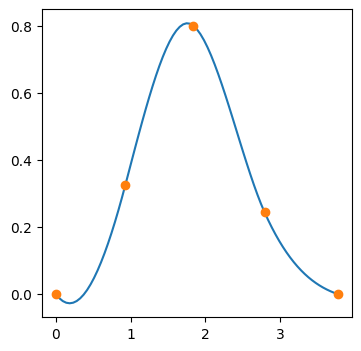

In [272]:
import matplotlib.pyplot as plt 
fig,ax = plt.subplots(figsize=(4,4),dpi=100)
nebtools = NEBTools(neb)
Ef, dE = nebtools.get_barrier()
fit = nebtools.get_fit()
ax.plot(fit[2], fit[3])
ax.plot(fit[0], fit[1],linestyle='none',marker='o')

In [232]:
nebimages = ineb.neb_create(ii,ff,nimages=5)

In [234]:
for i,image in enumerate(nebimages):
    AseAtomsAdaptor().get_structure(image).to(filename='{}.vasp'.format(i),fmt='poscar')

In [235]:
! open {0..5}.vasp 

In [ ]:
ineb.interstitialcy_mappings

In [286]:
numbers = []
for i,(k,v) in enumerate(ineb.interstitialcy_mappings.items()):
    for kk in v:
        numbers.append(os.path.join('./',str(k),str(kk)))

    
numbers

['./0/0', './0/8', './2/20', './2/8', './4/20', './4/0', './128/20']